In [1]:
import pandas as pd
import numpy as np
import torch
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt


from elo import update, initialize_elo

In [2]:
df = pd.read_csv("./data/archive/spreadspoke_scores.csv")

## Preprocess

columns = ['schedule_date', 'team_home', 'team_away', 'score_home', 'score_away', 'over_under_line']
df = df[columns]

# Convert schedule to date format (so we can compare dates)
df['schedule_date'] = pd.to_datetime(df['schedule_date']).dt.date
# df = df[df['schedule_date'] > datetime.date(1999, 1, 1)]

# Remove team locations (New England Patriots -> Patriots)
df['team_home'] = df['team_home'].str.split(' ').str[-1]
df['team_away'] = df['team_away'].str.split(' ').str[-1]

# Retroactively correct re-named teams
df.replace(to_replace="Team", value="Commanders", inplace=True)  # Washington Football Team -> Washington Commanders
df.replace(to_replace='Redskins', value='Commanders', inplace=True)
df.replace(to_replace='Oilers', value='Titans', inplace=True)

print(df.head())

  schedule_date team_home team_away  score_home  score_away over_under_line
0    1966-09-02  Dolphins   Raiders          14          23             NaN
1    1966-09-03    Titans   Broncos          45           7             NaN
2    1966-09-04  Chargers     Bills          27           7             NaN
3    1966-09-09  Dolphins      Jets          14          19             NaN
4    1966-09-10   Packers     Colts          24           3             NaN


Now we'll go through the entire database and update each team's elo game-=by-game.

In [3]:
elos = initialize_elo(None)  # Initialize all elo to 1600

historical = {}
for team in elos:
    historical[team] = []
    
for ind, row in df.iterrows():
    A, B = elos[row['team_home']], elos[row['team_away']]
    elos[row['team_home']], elos[row['team_away']] = update(A, B, row['score_home'], row['score_away'])
    
    # Keep track 
    historical[row['team_home']].append( elos[row['team_home']] )
    historical[row['team_away']].append( elos[row['team_away']] )

Reading ./data/Elo_2022.csv


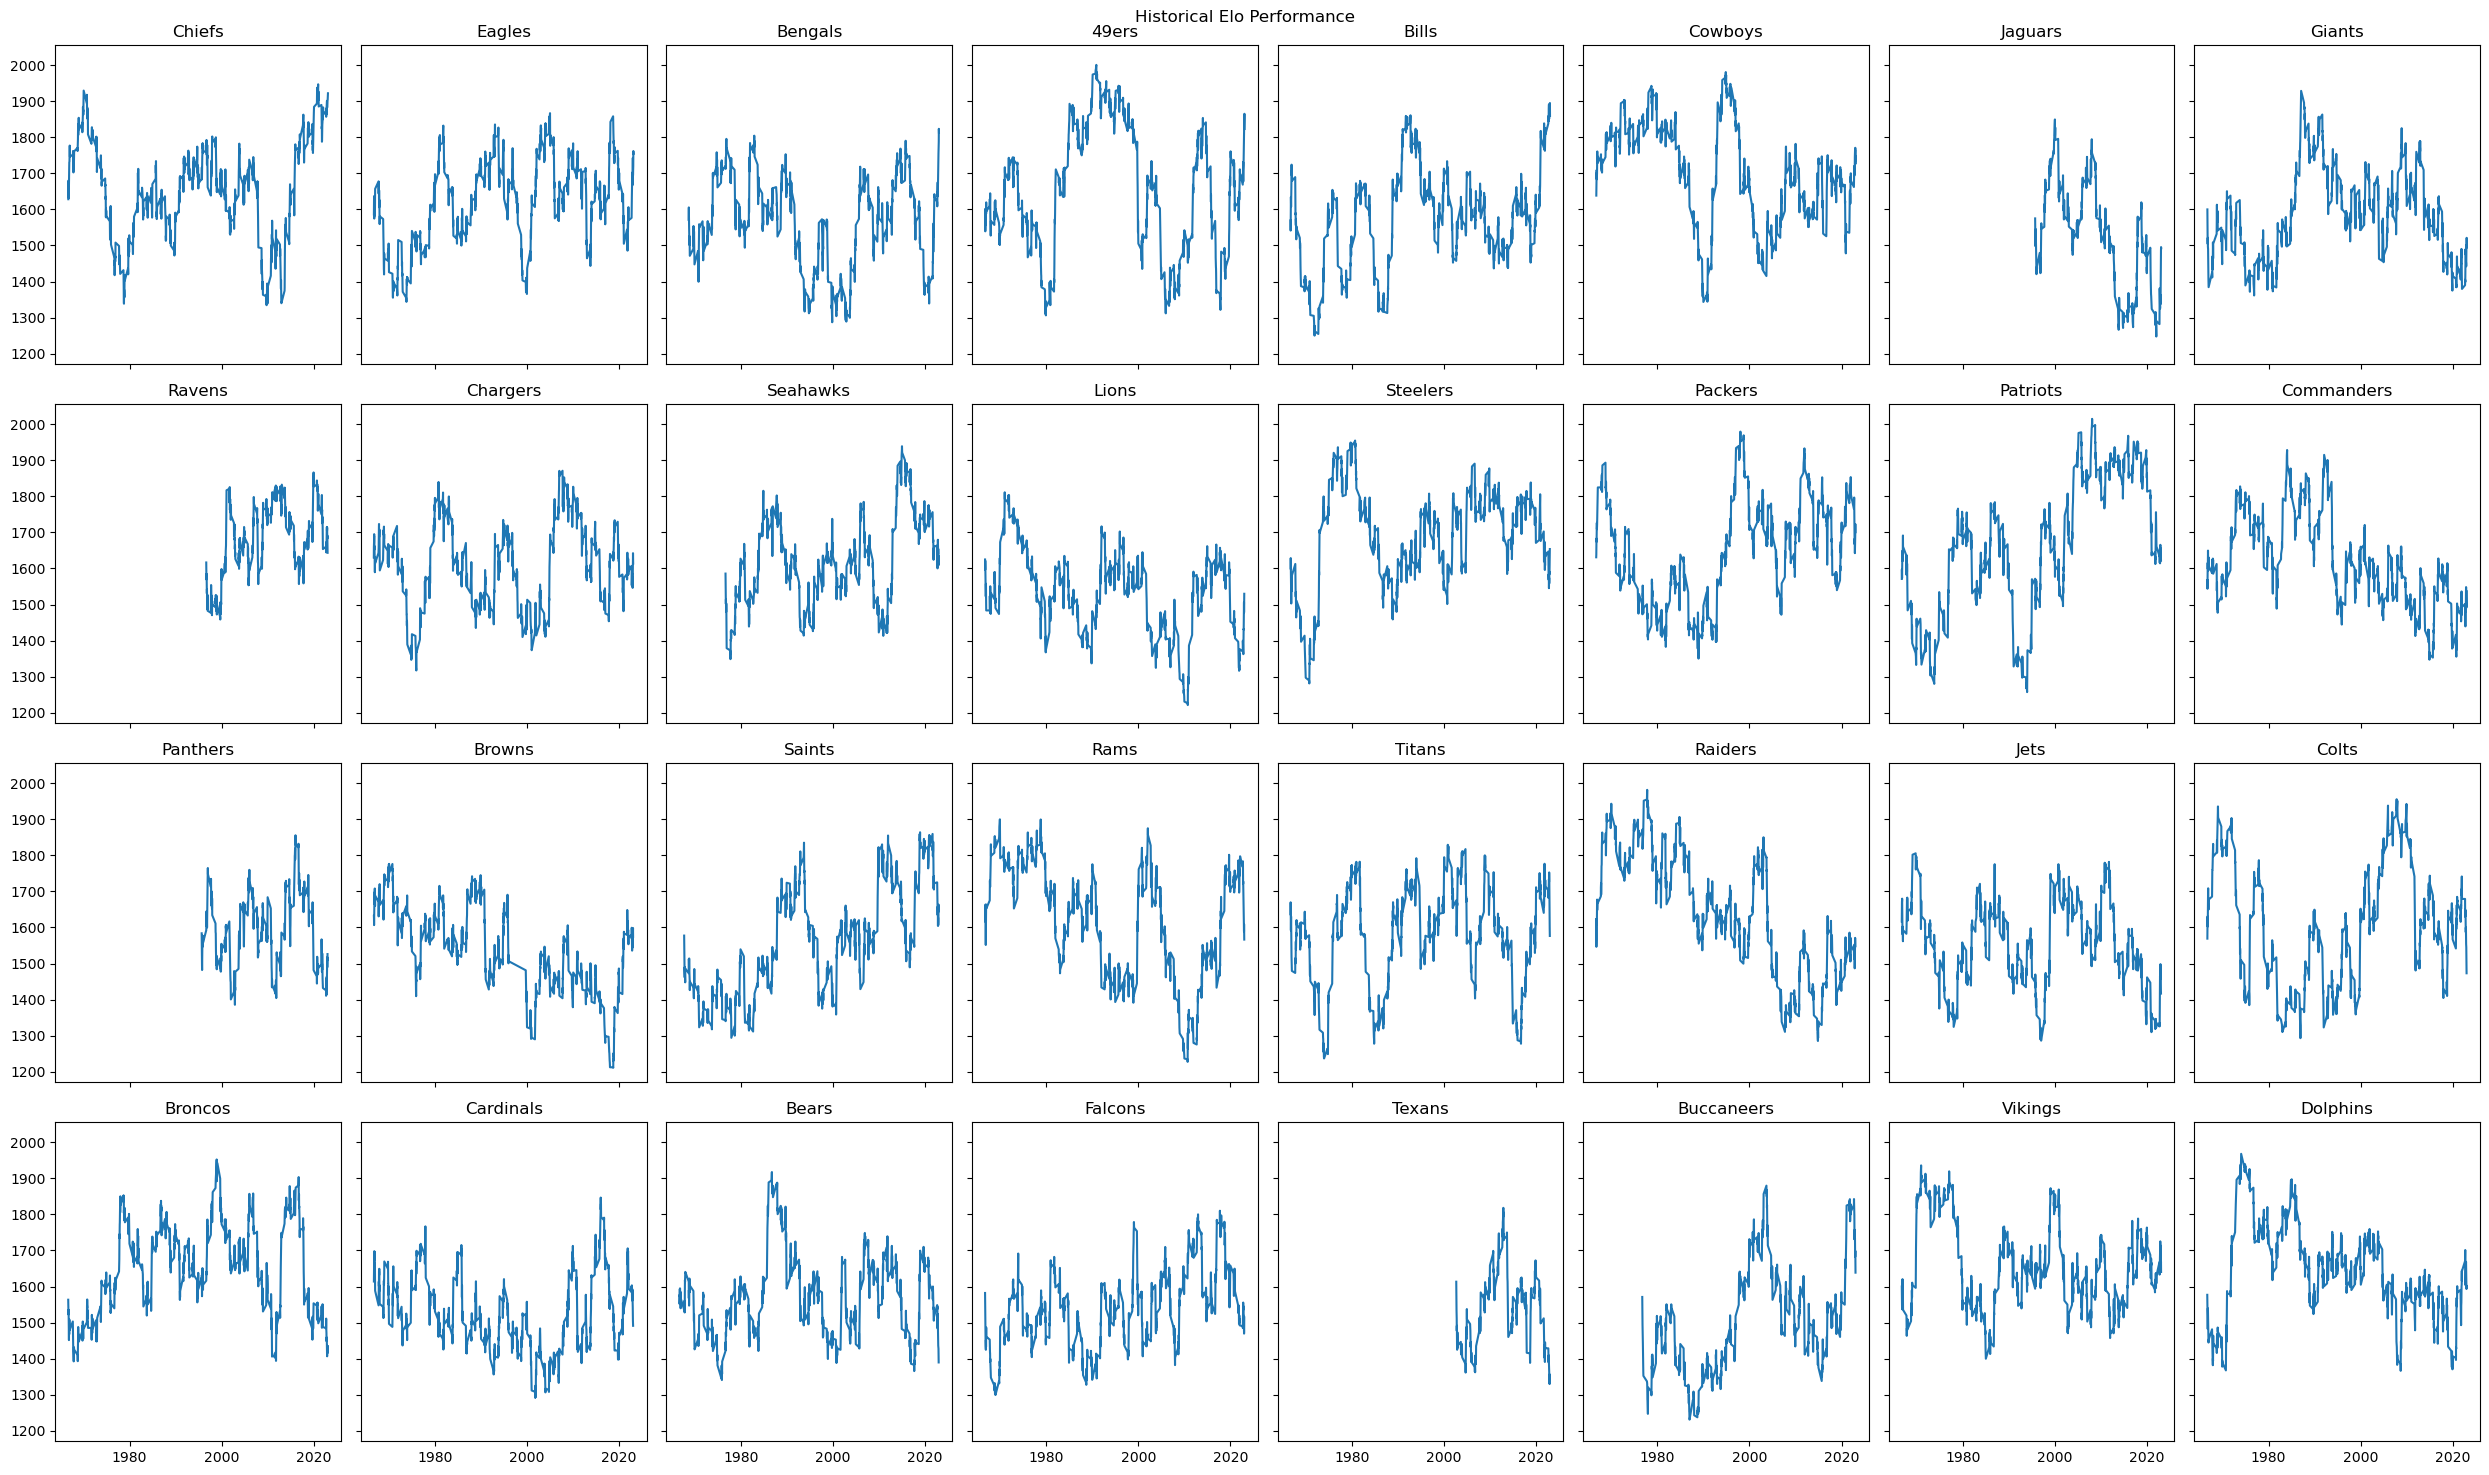

In [4]:
fig, axes = plt.subplots(ncols=8, nrows=4, figsize=(25, 15),
                         sharex=True, sharey=True)

# team = 'Patriots'
fig.suptitle('Historical Elo Performance')
for team,ax in zip(elos, axes.flat):
    dates = pd.to_datetime(df[(df['team_home'] == team) | (df['team_away'] == team)]['schedule_date']).dt.date
    ax.plot(dates, historical[team])
    ax.set_title(f"{team}")
    
    # ax.set_xticklabels(dates, rotation=90)
    locator = mdates.AutoDateLocator(minticks=4, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
fig.tight_layout()
plt.show()

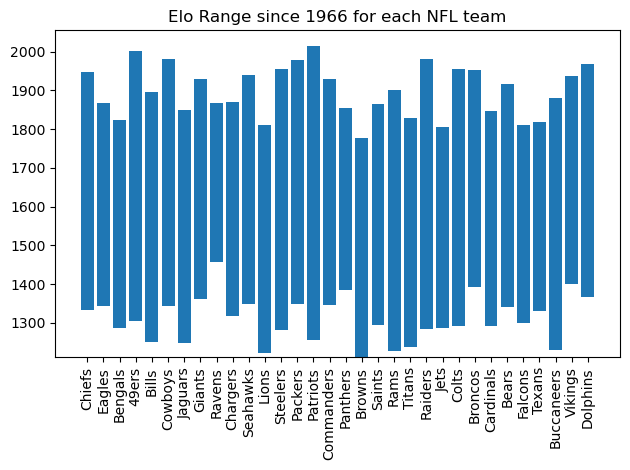

In [16]:
team_max = {team:max(historical[team]) for team in elos}
team_min = {team:min(historical[team]) for team in elos}

plt.title(f"Elo Range since {min(pd.to_datetime(df['schedule_date']).dt.year)} for each NFL team")
teams = [team for team in elos]
ranges = [team_max[team] - team_min[team] for team in elos]
mins = [team_min[team] for team in elos]
plt.bar(teams, 
        ranges,
        bottom = mins)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()